<h1 style="font-size:30px;">Data Preparation </h1>

In this section will be preparing our data so that we can use is to train our model. We have to makesure that our data is fully prepared before we give it to our model to train on.

So, in brief, we will shall download our dataset first which is already splitted into train and validation sets. Then we shall convert our train and validation data into what is referred to as **TF Records**. Finally we will visualize a few samples from the generated TF records for the validation data.

# Table of Contents

* [1 Install the TFOD API](#1-Install-the-TFOD-API)
* [2 Download the Data](#2-Download-the-Data)
* [3 Download and Extract Utility Scripts](#3-Download-and-Extract-Utility-Scripts)
* [4 Generate a LabelMap File](#4-Generate-a-LabelMap-File)
* [5 Generate TF Records](#5-Generate-TF-Records)
* [6 Visualize the Dataset from TF Records](#6-Visualize-the-Dataset-from-TF-Records)

## 1 Install the TFOD API

In [ ]:
# You need to update OpenCV if you are using Colab.
# Uncomment this line if you are using Colab.
!pip install opencv-python --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Clone the GitHub Repo**

Here we will clone the TFOD API repo.

In [ ]:
import os

if not 'models' in os.listdir():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# The `%%bash` magic command inside a notebook lets you run a cell run like a shell interface
# Note: the `bash` command works only on Colab.
%%bash 

# Change the directory to models/research
cd models/research/

# Compile the API's Protobuf files
protoc object_detection/protos/*.proto --python_out=.

# Copy the required Setup file
cp object_detection/packages/tf2/setup.py .

# Install the API using the setup.py file
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694955 sha256=c185a308ea56eafe2f5b24ac0ba71f6bbb3926bec8c22fa3bb4d465cb9fd8448
  Stored in directory: /tmp/pip-ephem-wheel-cache-74i_r1da/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
from zipfile import ZipFile
import urllib
import requests

from io import BytesIO
from urllib.request import urlopen

import cv2

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

## 2 Download the Data

In order to train an Object Detector we first need a dataset that is already annotated with bounding boxes and the correct labels for each class.

If you want to train a detector on a custom class and you can't find a dataset for that online, then you'll need to annotate the data yourself. You can use an annotating tool like [LabelImg](https://github.com/tzutalin/labelImg), [labelme](https://github.com/wkentaro/labelme) or [Roboflow](https://roboflow.com/) to easily annotate images. However, for this course, we would provide you the dataset itself; and we shall not cover the details of manually annotating data.

The data we will be using for this notebook is the **Pascal VOC 2012** Dataset. However, we shall be using only a subset of this data across just 4 classes instead of the original 20 classes. The entire dataset can be found [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).


In total we have 4 different kind of Vehicles:

* **Car**
* **Dog** 
* **Person**
* **TV Monitor**

<center><img src="https://opencv.org/wp-content/uploads/2022/07/TFOD_feature_image.png" width="350" height="640"></center>

In [ ]:
def download_file(url, save_name):
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
# Download the PASCAL VOC subset data.
download_file(
                  'https://www.dropbox.com/s/415tmokwg5xkw99/pascal_voc_subset_data.zip?dl=1', 
                  'pascal_voc_subset_data.zip'
                 )

We have downloaded the the dataset and now we will extract it.

In [ ]:
unzip(zip_file='pascal_voc_subset_data.zip')

Extracted all


Now, we will have a look at the XML files which basically contains the annotations in **`Pascal VOC`** format

```xml
<annotation>
	<folder>VOC2012</folder>
	<filename>2008_000016.jpg</filename>
	<source>
		<database>The VOC2008 Database</database>
		<annotation>PASCAL VOC2008</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>1</segmented>
	<object>
		<name>tvmonitor</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<occluded>0</occluded>
		<bndbox>
			<xmin>91</xmin>
			<ymin>15</ymin>
			<xmax>392</xmax>
			<ymax>353</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
</annotation>
```

The structure of the entire XML file can be broken down into the following components:

- `filename` : Filename of the image

- `size` : Image size (specifying the height, width and the number of channels)

- `name` : Name of the object

- `bndbox` : Containing the bounding box co-ordinates for the corresponding object (in `[xmin, ymin, xmax, ymax]` format)

## 3 Download and Extract Utility Scripts

In [ ]:
if not os.path.exists('tfod_utils'):
    download_file(
                  'https://www.dropbox.com/sh/i5uds5hgzc0phik/AADHAlWQk7VmTSFtoWj9pBZJa?dl=1', 
                  'tfod_utils_pascal_voc_subset.zip'
                 )
    unzip(zip_file='tfod_utils_pascal_voc_subset.zip')

## 4 Generate a LabelMap File

Now that we have downloaded our dataset, its time to convert it into tfrecords, which is the data format that is required by TensorFlow Object Detection API.

Before we can do that that we need to create a Label Map file (`.pbtxt`) which essentially is just an integer mapping of class labels.

So here you assign every class an integer value.

For e.g. if you have 2 classes cat and dog.

Then you would do something like:

`item { name: "Cat", id: 1}`

`item { name: "Dog", id: 2}`


If you have more classes the you would continue to add on like this and keep the incrementing the integer values.

**Note:** We did'nt used the id number `0` because that is reserved for the background class. 

In [ ]:
# Create Label Map of the Dataset
pbtxt = '''
item {
    name: 'car',
    id: 1,
}

item {
    name: 'dog',
    id: 2,
}

item {
    name: 'person',
    id: 3,
}

item {
    name: 'tvmonitor',
    id: 4,
}
'''

# Save this labelmap to disk
with open("labelmap.pbtxt", "w") as text_file:
    text_file.write(pbtxt)

## 5 Generate TF Records

As we dicussed before, we need to convert our data into TensorFlow Records most commonly known as TF Records. 

As discussed in previous modules, TF Records is simply a new format to store data based on the Protbufs. They help make the data reading/processing computationally more efficient then other formats like JSON, XML, CSV. The only downside they have are binary files so they are not human readable.

Also It's a requirement by **TFOD API** that your data should be in TFrecords.

### 5.1 Parse XML files into CSV files

Before we convert our data into tf records, we will parse all the XML annotation files into CSV

The following function from **`xml_to_csv.py`** in the **`tfod_utils`** folder parses the XML file into a data frame which can be subsequently transformed into a CSV file.

```python
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
            
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
```

Now, let's create a CSV file for the validation data

In [ ]:
# Create a csv file for the validation data.
!python ./tfod_utils/xml_to_csv.py -x val -c val_data.csv

Successfully converted xml to csv.


### 5.2 Create TF Examples

`TFRecordWriter` needs a special dictionary called `tfexample` so we need to create that. The function `create_tf_example` from **`generate_tfrecord.py`** in the **`tfod_utils`** folder and outputs a tfexample.

```python
def create_tf_example(group, path):
    ...
    
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

```

From the above function definition, we can see that image attributes are of the following types:

- image height and width of type: `tf.train.Int64List`

- The image (encoded in bytes format) of type: `tf.train.BytesList`

- class ids of type: `tf.train.Int64List`

- class labels of type: `tf.train.BytesList`

- bounding box coordinates of type: `train.train.FloatList`

### 5.3 Create TF Records

We will use the method above in the function below to create the Tf records. This fucntion utilizes tf writer to create tfrecords.

```python
def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))
```

Finally, we create the **tf record** from the CSV file for the validation data.

For this, we need to run the `generate_tfrecord.py` script that takes the following arguments:

* `--csv_input`: Path to the CSV file.
* `--output_path`: Path to the tfrecord.
* `--image_dir`: Path to the image directory.
* `--labelmap_path`: Path to the label map file.

In [ ]:
# Create tf_record for val data.
!python ./tfod_utils/generate_tfrecord.py --csv_input=val_data.csv --output_path=val_data.tfrecord --image_dir=val --labelmap_path=labelmap.pbtxt

2022-07-26 07:22:47.509697: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/val_data.tfrecord


## 6 Visualize the Dataset from TF Records

In this section we wil visualize the train and test TF Records files we just created to get a better intuition about our data and see that how each image looks with it's associated bounding boxes.

To do this we will need to create 2 functions:
* **`parse_record()`:** Parses the TF record files to get the information we need from itto visualize our data.
* **`view_records()`:** Uses the information returned from `parse_record` and visualizes the images.

In [ ]:
color_dict = {'car': (255,255,0), 'dog': (0,255,0), 'person': (255,125,125), 'tvmonitor': (0,255,255)}

### 6.1 Create Parse Record Function

We will create a function to parse tfrecord files. In this function we will create a dictionary of features we want to extract from the TF Records File. The features can be bounding boxes of objects in images, their labels, and the name of the image these bounding boxes are associated with. Then we parse the TF records through TensorFlow and read the information into variables we will use to visualize the data later on.

In [ ]:
# Method to parse the TF Record so we can visualize it.
def parse_record(data_record):
    """
    Parse the data record from a tfrecord file, typically pulled from an iterator,
    in this case a one_shot_iterator created from the dataset.

    Args:
    data_record:  Path for the TF Record we want to parse
    """

    # Initialize a feature dictionary containing the information we want from the 
    # the TF Record file after it is parsed.
    feature = {'image/encoded': tf.io.FixedLenFeature([], tf.string),
                  'image/object/class/label': tf.io.VarLenFeature(tf.int64),
                  'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
                  'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
                  'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
                  'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
                  'image/filename': tf.io.FixedLenFeature([], tf.string)
                  }

    # Parse each entry in the TF Record.
    parsed_example = tf.io.parse_single_example(data_record, feature)

    # Get File name from parsed entry.
    fname = parsed_example['image/filename'].numpy()

    # Get the encoded from parsed entry.
    encoded_image = parsed_example['image/encoded']

    # Decode the image into an array.
    image_np = tf.image.decode_image(encoded_image, channels=3).numpy()

    # Convert Sparse Tensor to Dense tensor so we get the complete information
    # regarding each of the features.
    labels =  tf.sparse.to_dense(parsed_example['image/object/class/label'],
                                    default_value=0).numpy()
    x1norm =  tf.sparse.to_dense(parsed_example['image/object/bbox/xmin'],
                                    default_value=0).numpy()
    x2norm =  tf.sparse.to_dense(parsed_example['image/object/bbox/xmax'],
                                    default_value=0).numpy()
    y1norm =  tf.sparse.to_dense(parsed_example['image/object/bbox/ymin'],
                                    default_value=0).numpy()
    y2norm =  tf.sparse.to_dense(parsed_example['image/object/bbox/ymax'],
                                    default_value=0).numpy()

    # Number of bounding boxes in an image.
    num_bboxes = len(labels)

    # Get height and width of image.
    height, width = image_np[:, :, 1].shape

    # Return the Parsed TF Recrods Image attributes.
    return fname, image_np, labels, x1norm, x2norm, y1norm, y2norm, num_bboxes, height, width

### 6.2 Create View Records Function
After parsing the tfrecords, we will create another function will allow us to view the images along with it's annotations.


In [ ]:
# Method to Visualize the TF Records File 
def view_records(file_path, class_labels):
    """
    Peek at the data using OpenCV and TensorFlow tools.
    
    Args:
      file_path: Path to tfrecord file (usually has 'record' extension)
      class_labels: Dictionary of labels with name:number pairs (start with 1)
      verbose (default 1): Display text output if 1, display nothing except 
      images otherwise.
    """

    # Read the TF Record Dataset
    dataset = tf.data.TFRecordDataset([file_path])

    # Convert the dataset into an iterator so we can loop through images
    record_iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)

    # Find the number of images and their labels in our dataset
    num_records = dataset.reduce(np.int64(0), lambda x, _: x + 1).numpy()

    # Loop over the 10 images to visualize the dataset
    for im_ind in range(10):

        # Parse each entry in the TF Record
        parsed_example = parse_record(record_iterator.get_next())

        # Get attributes about each image after being parsed
        fname, image_np, labels, x1norm, x2norm, y1norm, y2norm, num_bboxes, height, width = parse_record(record_iterator.get_next())

        # Create a copy of the image we read so original image stays same
        image_copy = image_np.copy()

        # Convert the image to RGB
        image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

        # Check to see if an image has bounding boxes
        if num_bboxes > 0:

            # Multiply the width and height bounding box values to rescale them
            # Back to their original value
            x1 = np.int64(x1norm*width)
            x2 = np.int64(x2norm*width)
            y1 = np.int64(y1norm*height)
            y2 = np.int64(y2norm*height)

            # Loop over the number of the bounding boxes so each one can be drawn
            for bbox_ind in range(num_bboxes):

                # Create a tuple of the bbox values
                bbox = (x1[bbox_ind], y1[bbox_ind], x2[bbox_ind], y2[bbox_ind])

                # Get the Label Name of each of the bounding box
                label_name = list(class_labels.keys())[list(class_labels.values()).index(labels[bbox_ind])]

                color = color_dict[label_name]

                # Draw the bounding box
                cv2.rectangle(image_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), 
                                color, 2)
                
                # Get text width and height
                ((text_width, text_height), _) = cv2.getTextSize(label_name, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2) 
                
                cv2.rectangle(image_rgb, (bbox[0], bbox[1] - int(0.9 * text_height)), (bbox[0] + int(0.4*text_width), bbox[1]), color, thickness=-1)

                # Write the detected class name for each bounding box
                cv2.putText(image_rgb, label_name,
                            (bbox[0],bbox[1] - int(0.3 * text_height)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)


        # Show the image
        plt.figure(figsize=(10,10));
        plt.imshow(image_rgb[...,::-1]);
        plt.axis('off');
        plt.title(f"Height/Width: {height, width}, Num bboxes: {num_bboxes}")

Call the function above and provide it a tfrecord file

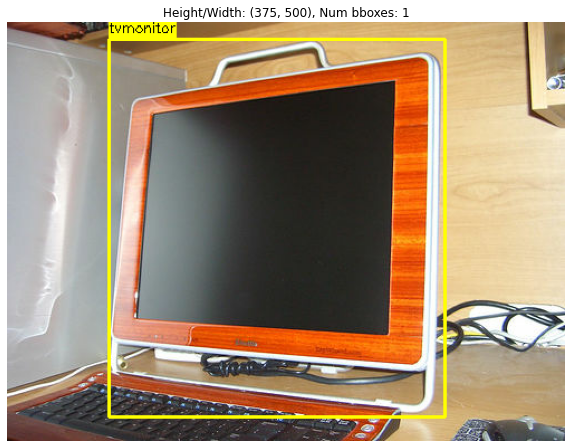

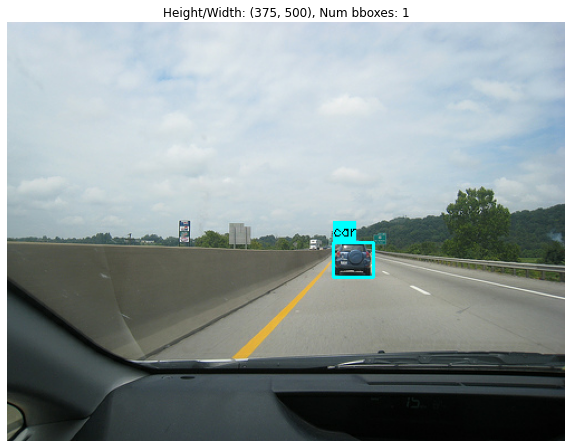

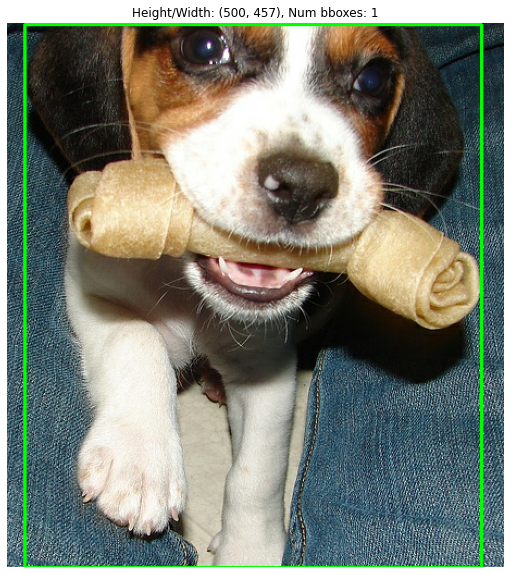

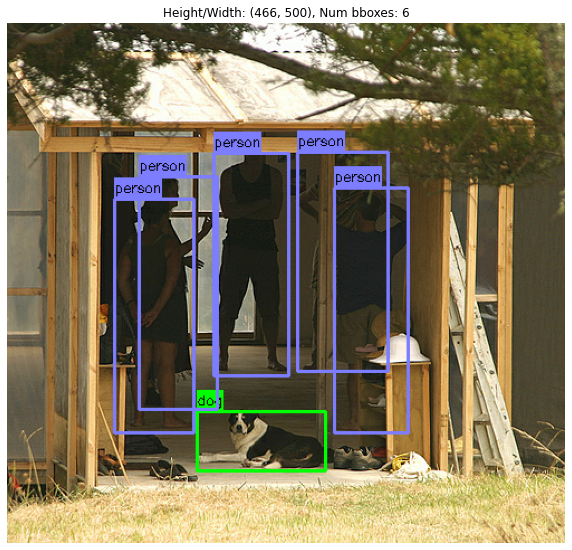

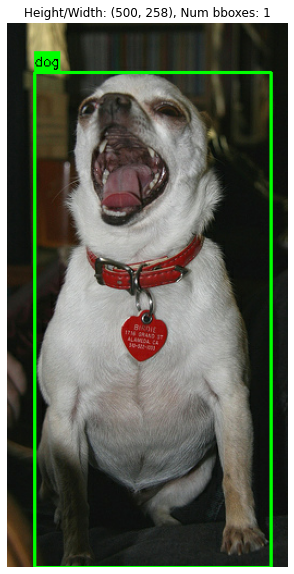

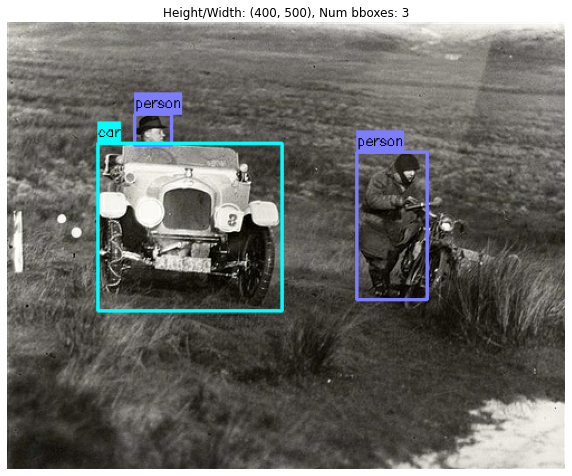

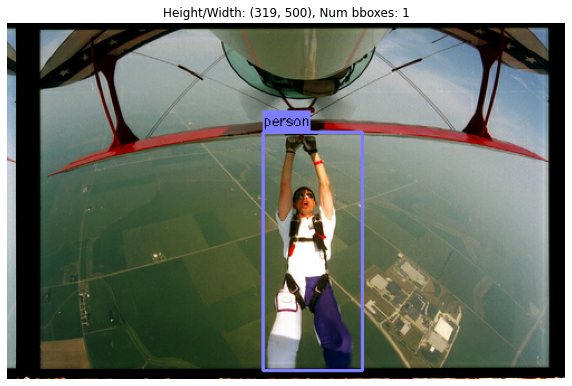

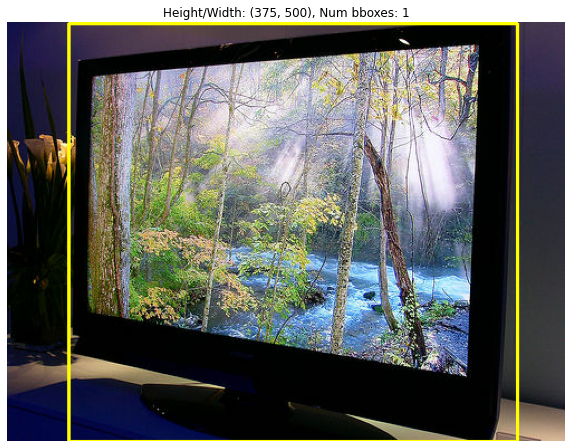

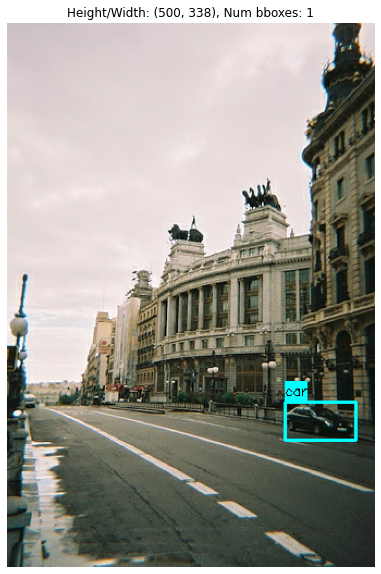

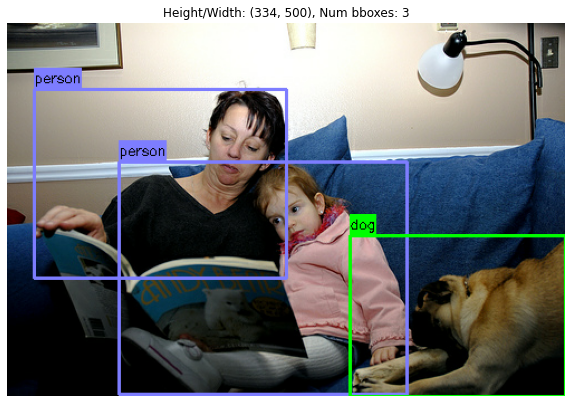

In [ ]:
# Create a class_labels dictionary same as the label map
class_labels =  {"car" : 1, "dog": 2, "person": 3, "tvmonitor": 4}


# We're Visualizing the train TF Record, you can also visualize the test record file.
data_path = "val_data.tfrecord"

# Call the view_records 
view_records(data_path, class_labels)

## References

* https://github.com/datitran/raccoon_dataset